# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [531]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [532]:
n = 10
p = np.array([8, 2]) / n
np.round(-(p * np.log(p)).sum(), 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [533]:
def H(R) -> np.float64:
    if not isinstance(R, np.ndarray):
        R = np.array(R)
    unique_r, counts = np.unique(R, return_counts=True)
    p = counts / counts.sum()
    return (p * (1 - p)).sum()

R_m = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2])
R_l = np.array([1, 1, 1, 1, 1, 1, 1, 1])
R_r = np.array([2, 2])
assert H(R_l) == 0
assert H(R_r) == 0
H(R_m) - len(R_l) / len(R_m) * H(R_l) - len(R_r) / len(R_m) * H(R_r)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [534]:
Y_leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
Y_leaf.mean()

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [535]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [536]:
def H_Gini(R: np.ndarray) -> np.float64:
    unique_r, counts = np.unique(R, return_counts=True)
    p = counts / counts.sum()
    return (p * (1 - p)).sum()

def weighted_ginis_real(X: np.ndarray, y: np.ndarray, H, t):
    mask = X < t
    R_l = y[mask]
    R_r = y[~mask]
    assert len(R_l)
    assert len(R_r)
    return (len(R_l) * H(R_l) + len(R_r) * H(R_r)) / len(y)
weighted_ginis_real = np.vectorize(weighted_ginis_real, otypes=[np.float64], excluded=[0, 1, 2])

def weighted_ginis_categorial(X: np.ndarray, y: np.ndarray, H, t):
    mask = X == t
    R_l = y[mask]
    R_r = y[~mask]
    assert len(R_l)
    assert len(R_r)
    return (len(R_l) * H(R_l) + len(R_r) * H(R_r)) / len(y)
weighted_ginis_categorial = np.vectorize(weighted_ginis_categorial, otypes=[np.float64], excluded=[0, 1, 2])

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if not isinstance(feature_vector, np.ndarray):
        feature_vector = feature_vector.to_numpy(copy=False)
    if not isinstance(target_vector, np.ndarray):
        target_vector = target_vector.to_numpy(copy=False)

    # Skip the least value because predicate is X < t (real) or X == t (categorical)
    # If features are constant then t_vals is empty and exception occurs
    t_vals = np.unique(feature_vector)[1:]
    
    assert feature_type in {"real", "categorical"}
    assert task in {"regression", "classification"}
    weighted_ginis_func = weighted_ginis_real if feature_type == "real" else weighted_ginis_categorial
    H_func = np.var if task == "regression" else H_Gini

    gini_vals = H_func(target_vector) - weighted_ginis_func(feature_vector, target_vector, H_func, t_vals)
    if not len(gini_vals):
        assert np.all(feature_vector[0] == feature_vector)
        return (gini_vals, gini_vals, None, 0)

    t_index = np.argmax(gini_vals)
    return (
        t_vals,
        gini_vals,
        t_vals[t_index],
        gini_vals[t_index]
    )

Эту функцию можно протестировать на датасете `California`.

In [537]:
from sklearn.datasets import fetch_california_housing

In [538]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [539]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [540]:
t_vals, gini_vals, t_vals_max, gini_vals_max = find_best_split(X.MedInc, y, task="regression", feature_type="real")

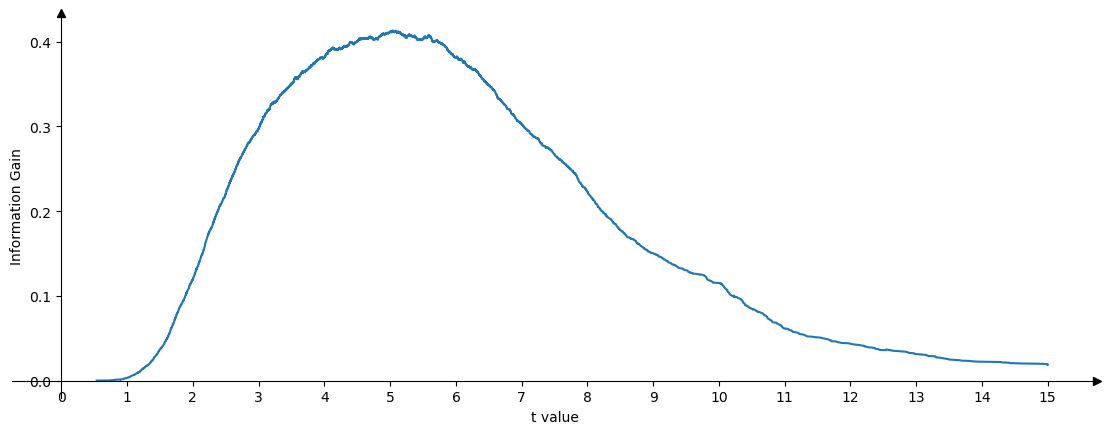

In [541]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(t_vals, gini_vals)
ax.set_xlabel("t value")
ax.set_ylabel("Information Gain")
ax.set_xticks(np.arange(int(t_vals.max()) + 2))
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [542]:
each_column_max_inf_gain = X.apply(lambda column: find_best_split(column, y, task="regression", feature_type="real")[2:], axis=0)
each_column_max_inf_gain

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,5.035300,52.000000,6.374545,1.103380,1161.000000,3.112628,37.940000,-121.860000
1,0.412751,0.030901,0.159208,0.015253,0.002831,0.073919,0.090334,0.050211


Чтобы думать, как дерево, надо стать деревом, поэтому выберем предикат жадным алгоритмом, т.е. предикат в корне будет:

In [543]:
index = each_column_max_inf_gain.iloc[1].argmax()
print("[{} < {}]".format(each_column_max_inf_gain.columns[index], each_column_max_inf_gain.iloc[1, index]))

[MedInc < 0.41275138620167695]


У MedInc также наибольшая по модулю корреляция с target:

In [544]:
X.corrwith(pd.Series(y))

MedInc        0.688075
HouseAge      0.105623
AveRooms      0.151948
AveBedrms    -0.046701
Population   -0.024650
AveOccup     -0.023737
Latitude     -0.144160
Longitude    -0.045967
dtype: float64

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

### $\cdot$ Обработка пропусков

Для обработки пропусков в данных реализуем алгоритм из пункта 6 [лекции 8 из курса МО1 с ПМИ](https://github.com/esokolov/ml-course-hse/blob/master/2023-fall/lecture-notes/lecture08-trees.pdf).

Цитирование материала из лекции as-is:

### 6 Обработка пропущенных значений
Одним из основных преимуществ решающих деревьев является возможность работы с пропущенными значениями. Рассмотрим некоторые варианты.

Пусть нам нужно вычислить функционал качества для предиката $\beta(x) = [x_j < t]$, но в выборке $R$ для некоторых объектов не известно значение признака $j$ — обозначим их через $V_j$. В таком случае при вычислении функционала можно просто проигнорировать эти объекты, сделав поправку на потерю информации от этого:

$$
Q(R, j, s) \approx \frac{\left|R \setminus V_j\right|}{|R|} \cdot Q(R \setminus V_j, j, s)
$$

Затем, если данный предикат окажется лучшим, поместим объекты из $V_j$ как в левое, так и в правое поддерево.

В имплементации класса `DecisionTree` данная опция включается / выключается в конструкторе параметром `handle_nan_values` (default = `True`)

### $\cdot$ Метод оценки важности признаков 

На лекции был упомянут (но, к сожалению, не рассмотрен) метод выбора важности признака на основе энтропий. Описание этого метода я нашёл [здесь](https://winder.ai/entropy-based-feature-selection/), в данной имплементации класса `DecisionTree` в начале фита для каждого признака вычисляется значение его важности при помощи методов `_calculate_entropy_based_feature_importance` и `_calculate_entropy_based_feature_importances`. Если в фит передан детафрейм, то ключ в словаре - `имя признака из датафрейма`, иначе - заглушка в виде `"feature_{i}"`

In [545]:
class DecisionTree:
    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        task: str = "classification",
        handle_nan_values: bool = True
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        assert max_depth is None or (int(max_depth) == max_depth and max_depth >= 1)
        self._max_depth = max_depth
        assert min_samples_split >= 2
        self._min_samples_split: int = int(min_samples_split)
        assert min_samples_leaf >= 1
        self._min_samples_leaf: int = int(min_samples_leaf)
        assert isinstance(handle_nan_values, bool)
        self._handle_nan_values: bool = handle_nan_values

        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

        # Depth of the tree after last fit
        self._fit_depth = 0

    def _calculate_entropy_based_feature_importance(self, feature: np.ndarray, y: np.ndarray):
        assert feature.ndim == 1

        unique_r, counts = np.unique(feature, return_counts=True)
        probability_of_each_feature_class = counts / counts.sum()
        t_vals = np.unique(feature)
        H = np.var if self.task == "regression" else H_Gini

        entropy_of_each_feature_class = np.array(list(map(lambda t: H(y[feature == t]), t_vals)))
        return np.multiply(entropy_of_each_feature_class, probability_of_each_feature_class).sum()
    
    def _calculate_entropy_based_feature_importances(self, X: Union[np.ndarray, pd.DataFrame], y: np.ndarray):
        feature_names = list(
            X.columns if isinstance(X, pd.DataFrame) \
                else map(lambda i: f"feature_{i}", range(X.shape[1])))

        if not isinstance(X, np.ndarray):
            X = X.to_numpy(copy=False)
        assert isinstance(X, np.ndarray) and X.ndim == 2

        feature_importances = np.apply_along_axis(
            lambda feature: self._calculate_entropy_based_feature_importance(feature, y),
            axis=0,
            arr=X)

        # Norm importances
        feature_importances /= feature_importances.sum()

        # Match each feature importance to feature name
        self._feature_importances = dict(zip(feature_names, feature_importances, strict=True))

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        current_depth: int
    ) -> None:
        assert sub_X.ndim == 2 and sub_y.ndim == 1 and sub_X.shape[0] == len(sub_y)
        # критерий останова
        if np.all(sub_y == sub_y[0]) or current_depth == self._max_depth or len(sub_y) < self._min_samples_split:
            self._make_node_terminal(node, sub_y, current_depth)
            return

        feature_best, threshold_best, gini_best = None, None, None
        split_mask = None
        split_mask_nans = None if not self._handle_nan_values else np.zeros(len(sub_y), dtype=np.bool_)
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            # categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            has_nans: bool = self._handle_nan_values
            if has_nans:
                nan_features_mask = np.isnan(feature_vector)
                has_nans = nan_features_mask.any()
            if has_nans:
                original_sub_y = sub_y
                sub_y = sub_y[~nan_features_mask]
                original_feature_vector = feature_vector
                feature_vector = feature_vector[~nan_features_mask]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(
                feature_vector, sub_y, self.task, feature_type)

            if has_nans:
                # Correct Q(R, j, s)
                # Q(R, j, s) = |R \ V_j| / |R| * Q(R \ V_j, j, s)
                gini *= len(sub_y) / len(original_sub_y)
                # Restore sub_y
                sub_y = original_sub_y

            if (gini_best is not None and gini <= gini_best) or threshold is None:
                continue

            feature_best = feature
            gini_best = gini

            if has_nans:
                split_mask_nans = nan_features_mask
                # Fill nans with threshold.
                original_feature_vector[nan_features_mask] = threshold
                # Restore feature_vector with filled values.
                feature_vector = original_feature_vector

            # split_mask - маска на объекты, которые должны попасть в левое поддерево
            match feature_type:
                case "real":
                    threshold_best = threshold
                    # If R has nans, this mask will send them to the left,
                    #  we will send them to the right manually later.
                    split_mask = feature_vector < threshold
                case "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    # If R has nans, this mask will send them to the right,
                    #  we will send them to the left manually later.
                    split_mask = feature_vector == threshold

        # записываем полученные сплиты в атрибуты класса
        if threshold_best is None:
            self._make_node_terminal(node, sub_y, current_depth)
            return

        assert isinstance(feature_best, int) and feature_best < sub_X.shape[1]
        assert gini_best is not None and np.isfinite(gini_best)
        assert isinstance(split_mask, np.ndarray) \
            and split_mask.ndim == 1 \
            and len(split_mask) == len(sub_y)
        if __debug__ and self._handle_nan_values:
            assert isinstance(split_mask_nans, np.ndarray) \
                and split_mask_nans.ndim == 1 \
                and len(split_mask_nans) == len(sub_y)

        # If split has nan values, send them to the both child nodes
        left_mask = split_mask
        if self._handle_nan_values:
            left_mask |= split_mask_nans
        right_mask = np.logical_not(split_mask)
        if self._handle_nan_values:
            right_mask |= split_mask_nans
        left_sub_y = sub_y[left_mask]
        right_sub_y = sub_y[right_mask]
        if len(left_sub_y) < self._min_samples_leaf or len(right_sub_y) < self._min_samples_leaf:
            self._make_node_terminal(node, sub_y, current_depth)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        match self._feature_types[feature_best]:
            case "real":
                node["threshold"] = threshold_best
            case "categorical":
                node["category_split"] = threshold_best

        node["left_child"], node["right_child"] = {}, {}

        self._fit_node(sub_X[left_mask], left_sub_y, node["left_child"], current_depth + 1)
        self._fit_node(sub_X[right_mask], right_sub_y, node["right_child"], current_depth + 1)

    def _make_node_terminal(self, node: dict, node_y: np.ndarray, node_depth: int):
        assert node_y.ndim == 1 and len(node_y) >= self._min_samples_leaf
        node["type"] = "terminal"
        node["class"] = Counter(node_y).most_common(1)[0][0]
        self._fit_depth = max(self._fit_depth, node_depth)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        i = node["feature_split"]
        match self._feature_types[i]:
            case "real":
                go_left = x[i] < node["threshold"]
            case "categorical":
                go_left = x[i] == node["category_split"]
        child = node["left_child"] if go_left else node["right_child"]
        return self._predict_node(x, child)

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        if not isinstance(y, np.ndarray):
            y = y.to_numpy(copy=False)
        assert isinstance(y, np.ndarray) and y.ndim == 1

        self._calculate_entropy_based_feature_importances(X, y)

        if not isinstance(X, np.ndarray):
            X = X.to_numpy(copy=False)
        assert isinstance(X, np.ndarray) and X.ndim == 2

        self._fit_node(X, y, self._tree, current_depth=0)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not isinstance(X, np.ndarray):
            X = X.to_numpy(copy=False)

        return np.apply_along_axis(lambda x: self._predict_node(x, self._tree), axis=-1, arr=X)


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [546]:
df = pd.read_csv("students.csv", index_col="Unnamed: 0")
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [547]:
X = df[["STG", "SCG", "STR", "LPR", "PEG"]]
y = df["UNS"]

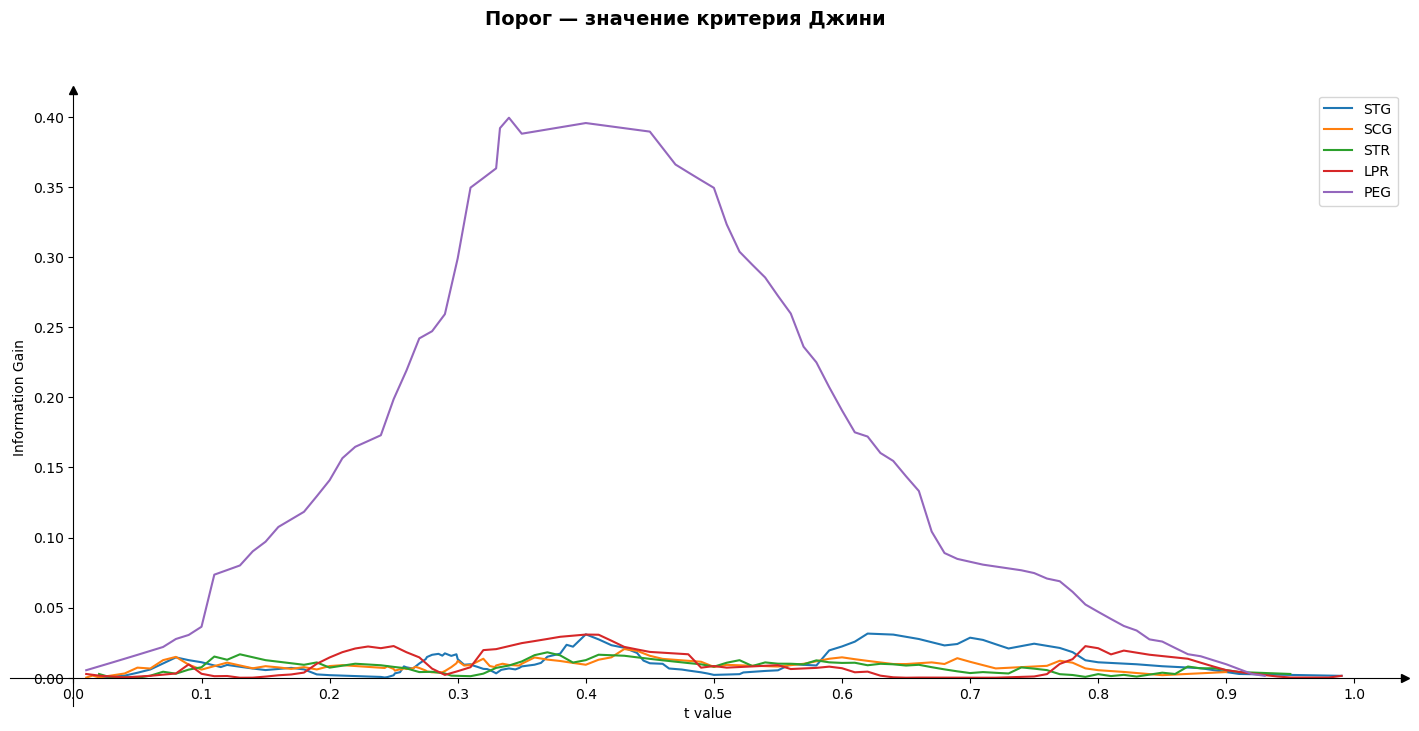

In [548]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle("Порог — значение критерия Джини", fontsize=14, fontweight="demibold")

for col in X:
    t_vals, gini_vals, t_vals_max, gini_vals_max = find_best_split(X[col], y, task="classification", feature_type="real")
    ax.plot(t_vals, gini_vals, label=col)

ax.set_xlabel("t value")
ax.set_ylabel("Information Gain")
ax.set_xticks(np.arange(0, 1.05, 0.1))
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.legend()
plt.show()

In [549]:
def plot_scatter(X, y, col_name):
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f"Значение признака {col_name} — класс", fontsize=14, fontweight="demibold")
    ax.scatter(x=X[col_name], y=y, label=col_name)
    ax.set_xlabel("t")
    ax.set_ylabel("class")
    ax.set_xticks(np.arange(0, 1.05, 0.1))
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_position(("data", 0))
    ax.spines["left"].set_position(("data", 0))
    ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    ax.legend(loc="center right")
    plt.show()

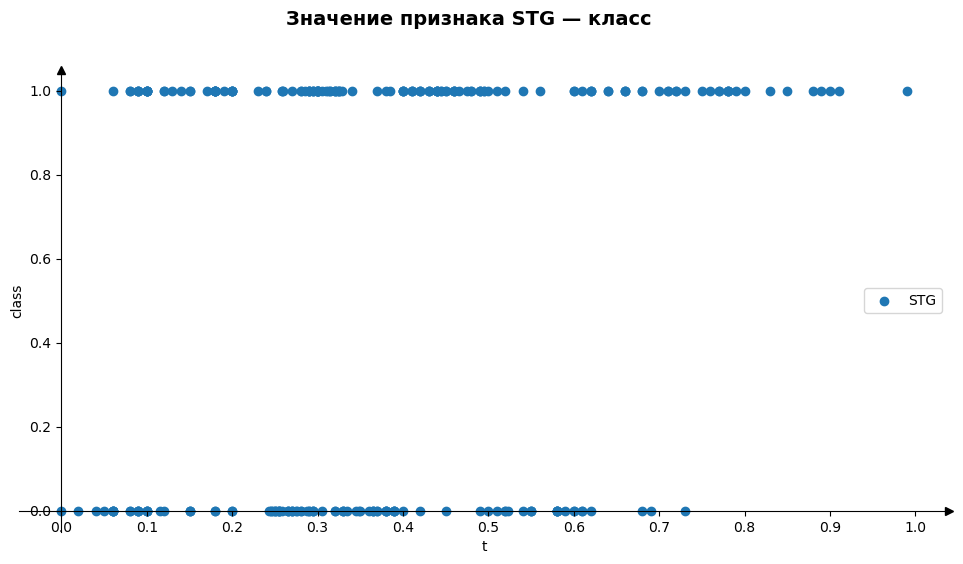

In [550]:
plot_scatter(X, y, "STG")

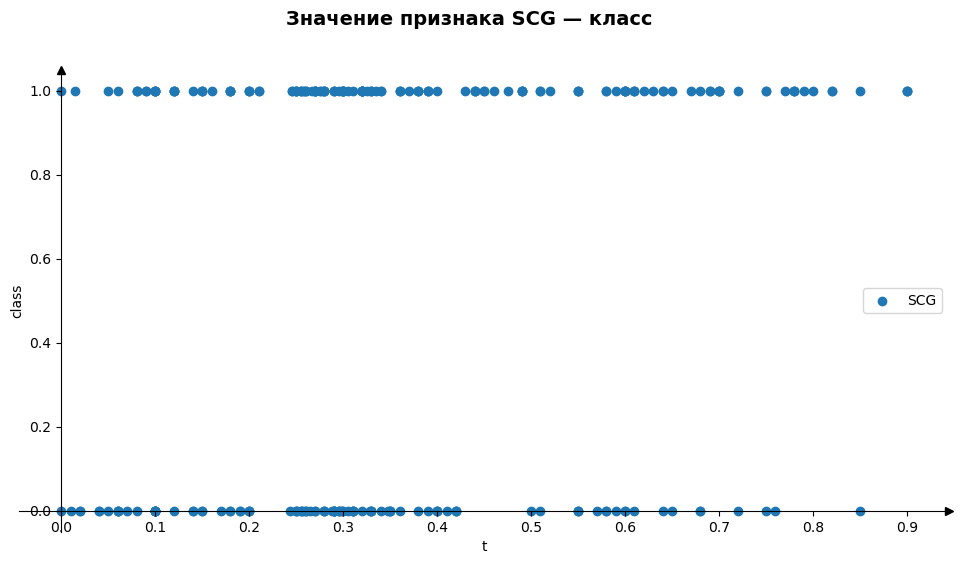

In [551]:
plot_scatter(X, y, "SCG")

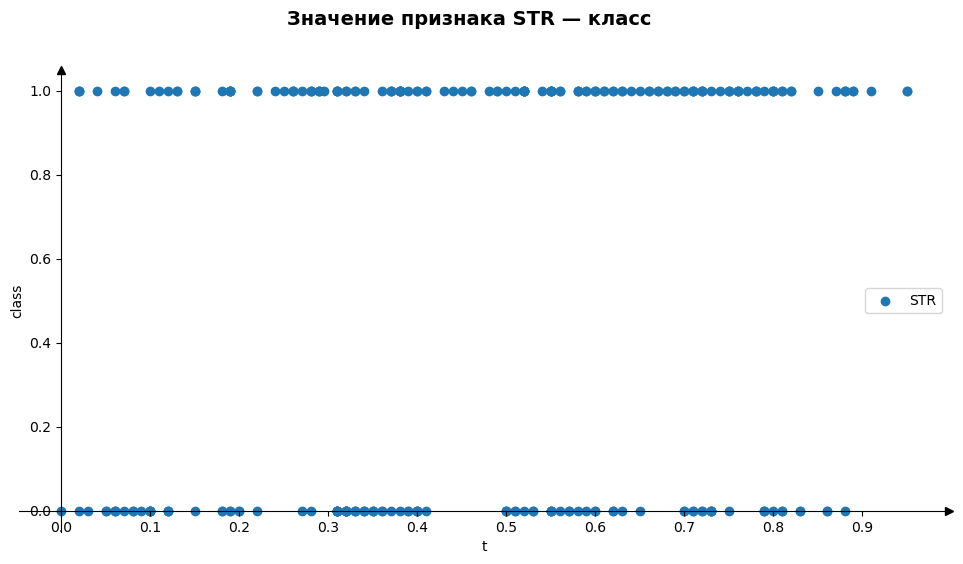

In [552]:
plot_scatter(X, y, "STR")

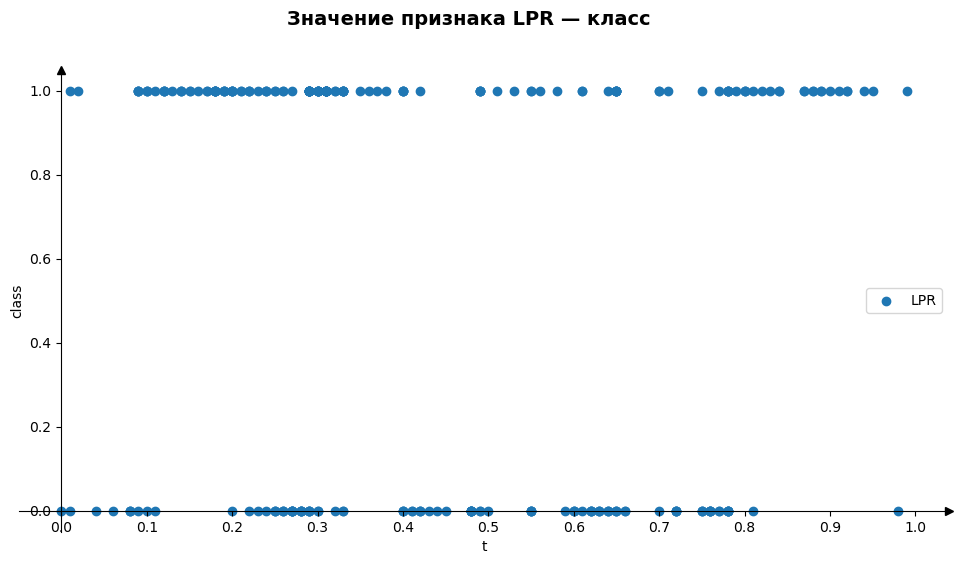

In [553]:
plot_scatter(X, y, "LPR")

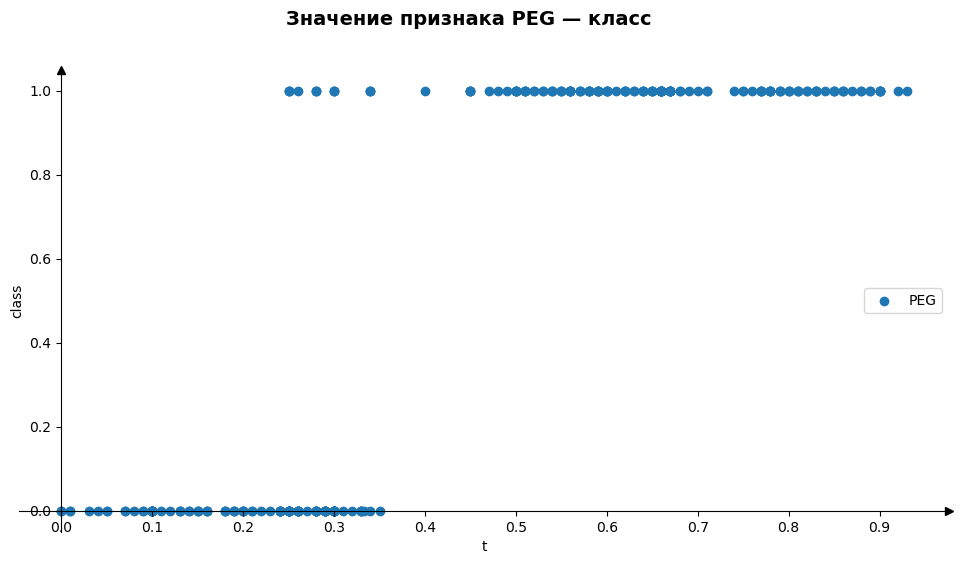

In [554]:
plot_scatter(X, y, "PEG")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Ответ:

Судя по кривым на 1-ом графике, лучше всего делить по PEG.

Это согласуется с диаграммами рассеяния (видно по последнему графику, можно провести прямую около x = 0.36, которая почти не ошибается)

Для PEG кривая на графике имеет "легко отличимый" глобальный максимум, а остальные локальные максимумы либо "почти равны" ему, либо "далеко" от него, а также прямо около глобального максимума сосредоточено относительно немного значений, т.е. можно однозначно выбрать значение порога $t \approx 0.34$. У остальных кривых для признаков, по которым деление практически невозможно, много локальных максимумов "близки" к глобальному, а также около них и глобального максимума сосредоточено достаточно много значений (можно сказать, что нет "пиковости", как на графике кривой для PEG)

In [555]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
# Кажется, на вопрос необходимо ответить текстом (выше), а не кодом

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [556]:
!pip install ucimlrepo

In [557]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo.dotdict import dotdict

# fetch dataset
mushroom: dotdict = fetch_ucirepo(id=73)
# data (as pandas dataframes)
X: pd.DataFrame = mushroom.data.features
y: pd.DataFrame = mushroom.data.targets

In [558]:
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [559]:
y.head()

,poisonous
0,p
1,e
2,e
3,p
4,e


In [560]:
from sklearn.preprocessing import LabelEncoder
X = X.apply(LabelEncoder().fit_transform)
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [561]:
y = y.apply(LabelEncoder().fit_transform)["poisonous"]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: poisonous, dtype: int32

In [562]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4062, 22), (4062, 22), (4062,), (4062,))

In [563]:
num_of_features = X_train.shape[1]
tree = DecisionTree(feature_types=["categorical"] * num_of_features, task="classification")
tree.fit(X_train, y_train)

In [564]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray):
    assert y_true.shape == y_pred.shape
    return (y_true == y_pred).sum() / len(y_true)

print(f"Accuracy: {accuracy(y_test, tree.predict(X_test))}")

Accuracy: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [287]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [288]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

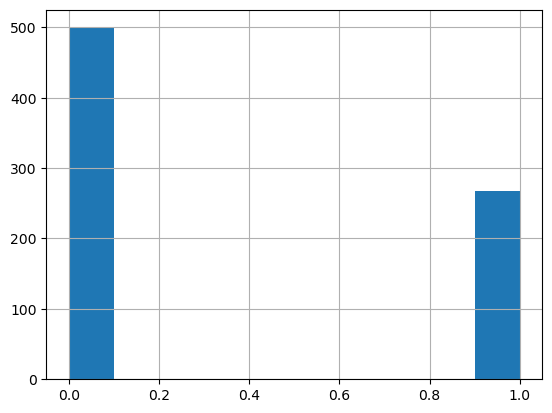

In [289]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [290]:
X = data[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]
y = data.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5466723)
X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=5466723)
y_train_train.shape, y_valid.shape, y_test.shape

((375,), (162,), (231,))

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [291]:
def f1_measure(y_true: np.ndarray, y_pred: np.ndarray):
    assert y_true.ndim == y_pred.ndim == 1 and len(y_true) == len(y_pred)
    r = recall_score(y_true, y_pred)
    p = precision_score(y_true, y_pred)
    return 2 * p * r / (p + r)

In [292]:
from itertools import product

max_depth_params = np.arange(1, 25)
min_sample_leaf_params = np.arange(1, 25)
max_f1_measure = float("-inf")
optimal_max_depth = None
optimal_min_samples_leaf = None
for max_depth, min_samples_leaf in product(max_depth_params, min_sample_leaf_params):
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf).fit(X_train_train, y_train_train)
    fm = f1_measure(y_valid, tree.predict(X_valid))
    if fm > max_f1_measure:
        max_f1_measure = fm
        optimal_max_depth = max_depth
        optimal_min_samples_leaf = min_samples_leaf

In [293]:
max_f1_measure

0.6666666666666666

In [294]:
optimal_max_depth

6

In [295]:
optimal_min_samples_leaf

13

In [296]:
tree = DecisionTreeClassifier(max_depth=optimal_max_depth, min_samples_leaf=optimal_min_samples_leaf).fit(X_train, y_train)
y_test_predicted = tree.predict(X_test)

In [297]:
def print_scores(y_true: np.ndarray, y_predicted: np.ndarray):
    print("Accuracy: {}\n"
          "Precision: {}\n"
          "Recall: {}\n"
          "ROC-AUC: {}\n".format(
                accuracy_score(y_true, y_predicted),
                precision_score(y_true, y_predicted),
                recall_score(y_true, y_predicted),
                roc_auc_score(y_true, y_predicted)
          ))

In [298]:
print_scores(y_test, y_test_predicted)

Accuracy: 0.7748917748917749
Precision: 0.7619047619047619
Recall: 0.5647058823529412
ROC-AUC: 0.730983078162772



**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [299]:
trees_ensemble = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=optimal_max_depth, min_samples_leaf=optimal_min_samples_leaf),
    n_estimators=50,
    n_jobs=-1).fit(X_train, y_train)
trees_ensemble

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                   min_samples_leaf=13),
                  n_estimators=50, n_jobs=-1)

In [300]:
print_scores(y_test, trees_ensemble.predict(X_test))

Accuracy: 0.7965367965367965
Precision: 0.796875
Recall: 0.6
ROC-AUC: 0.7554794520547945



**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [339]:
from sklearn.model_selection import cross_val_score

max_depth_params = np.arange(1, 25)
min_samples_split_params = np.arange(1, 25)
max_f1_measure = float("-inf")
optimal_max_depth = None
optimal_min_samples_leaf = None
for max_depth, min_samples_split in product(max_depth_params, min_samples_split_params):
    tree = RandomForestClassifier(n_estimators=50,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_split,
                                n_jobs=-1,
                                random_state=12)
    f1_scores: np.ndarray = cross_val_score(tree, X_train, y_train, cv=17, n_jobs=-1, scoring="f1", random_state=12)
    avg_f1_score = f1_scores.mean()
    if avg_f1_score > max_f1_measure:
        max_f1_measure = avg_f1_score
        optimal_max_depth = max_depth
        optimal_min_samples_leaf = min_samples_split

In [340]:
rf_model = RandomForestClassifier(n_estimators=50,
                              max_depth=optimal_max_depth,
                              min_samples_leaf=optimal_min_samples_leaf,
                              n_jobs=-1,
                              random_state=None)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=50,
                       n_jobs=-1)

In [341]:
print_scores(y_test, rf_model.predict(X_test))

Accuracy: 0.7878787878787878
Precision: 0.7571428571428571
Recall: 0.6235294117647059
ROC-AUC: 0.7535455278001612



В данном случае бэггинг и случайный лес имеют более высокие метрики, чем обычное решающее дерево, но между собой они похожи по метрикам качества: у бэггинга выше accuracy и precision, а у случайного леса немного выше recall

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

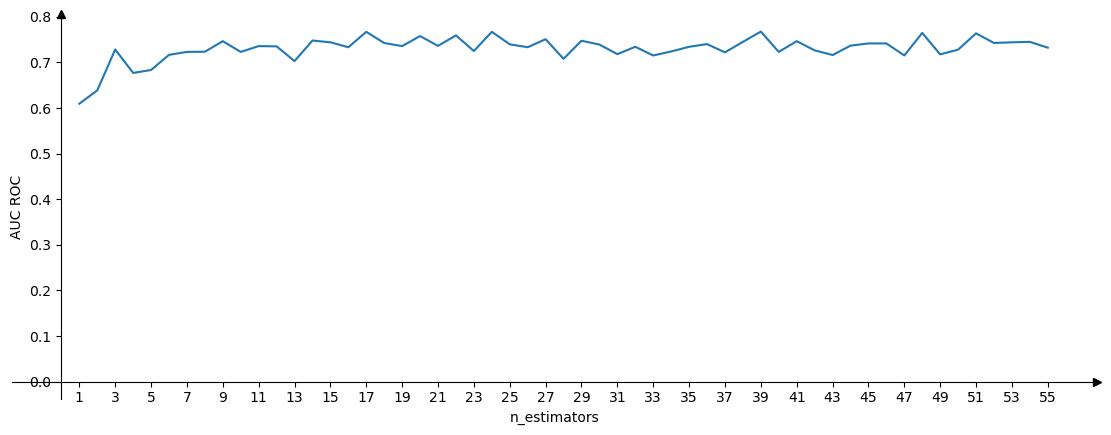

In [350]:
n_est_vals = np.arange(1, 56)
roc_auc_vals = [roc_auc_score(y_test, RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train).predict(X_test)) for n_estimators in n_est_vals]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(n_est_vals, roc_auc_vals)
ax.set_xlabel("n_estimators")
ax.set_ylabel("AUC ROC")
ax.set_xticks(np.arange(1, 56, 2))
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
plt.show()

В данном случае при достижении 9 деревьев в ансамбле качество композиции перестаёт существенно увеличиваться, а иногда при увеличении количества деревьев даже падает.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

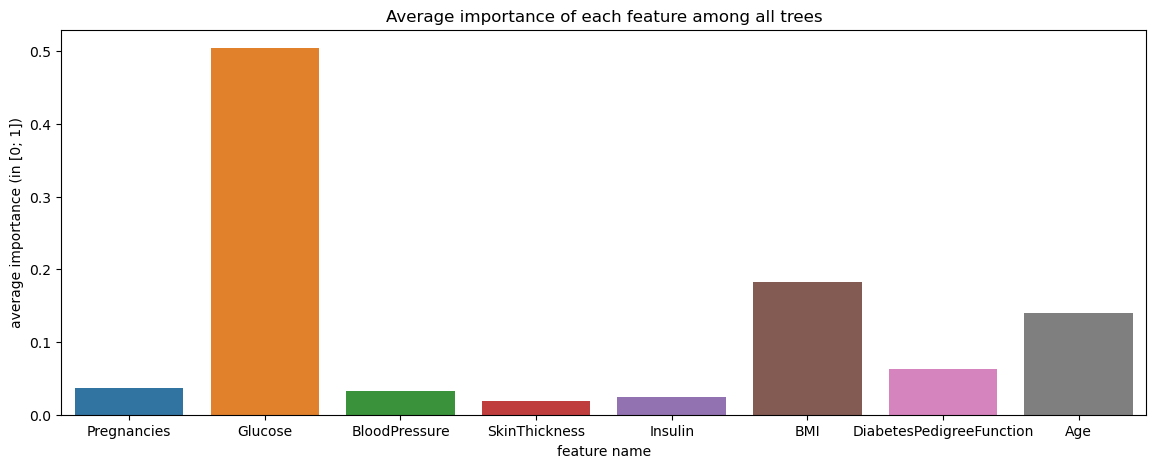

In [388]:
import seaborn as sns

trees_ensemble = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=6, min_samples_leaf=13),
    n_estimators=50,
    n_jobs=-1).fit(X_train, y_train)

mean_feature_importances = np.mean(np.array([tree.feature_importances_ for tree in trees_ensemble.estimators_]), axis=0)

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x=X_train.columns, y=mean_feature_importances, ax=ax)
ax.set_title("Average importance of each feature among all trees")
ax.set_xlabel("feature name")
ax.set_ylabel("average importance (in [0; 1])")
plt.show()

Судя по результатам усреднения важностей признаков по всем деревьям, самый важный признак - Glucose (концентрация глюкозы в плазме через 2 часа при пероральном тесте на толерантность к глюкозе)